In [1]:
import os
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error, r2_score

from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
mass_case_train_path = '/content/drive/MyDrive/Breast Cancer Image Dataset/csv/mass_case_description_train_set.csv'
mass_case_test_path = '/content/drive/MyDrive/Breast Cancer Image Dataset/csv/mass_case_description_test_set.csv'


In [4]:
mass_case_train = pd.read_csv(mass_case_train_path)
mass_case_test = pd.read_csv(mass_case_test_path)

In [5]:
mass_case_train.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [6]:
mass_case_test.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,Mass-Test_P_00017_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...
3,P_00017,2,LEFT,MLO,1,mass,ROUND,ILL_DEFINED,4,MALIGNANT,4,Mass-Test_P_00017_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....
4,P_00032,3,RIGHT,CC,1,mass,ROUND,OBSCURED,0,BENIGN,2,Mass-Test_P_00032_RIGHT_CC/1.3.6.1.4.1.9590.10...,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....


In [7]:
def columns_renaming(df):
  df = df.rename(columns={'left or right breast':'left_or_right_breast',
  'image view':'image_view','abnormality id':'abnormality_id','mass shape':'mass_shape',
  'mass margins':'mass_margins','image file path':'image_file_path', 'breast density': 'breast_density',
  'cropped image file path':'cropped_image_file_path', 'calc type': 'calc_type',
  'calc distribution':'calc_distribution', 'abnormality type':'abnormality_type',
  'ROI mask file path':'ROI_mask_file_path'})

  df['left_or_right_breast'] = df['left_or_right_breast'].astype('category')
  df['image_view'] = df['image_view'].astype('category')
  df['abnormality_type'] = df['abnormality_type'].astype('category')
  df['pathology'] = df['pathology'].astype('category')

  return df

In [8]:
mass_case_train = columns_renaming(mass_case_train)

print(mass_case_train.isna().sum())

patient_id                  0
breast_density              0
left_or_right_breast        0
image_view                  0
abnormality_id              0
abnormality_type            0
mass_shape                  4
mass_margins               43
assessment                  0
pathology                   0
subtlety                    0
image_file_path             0
cropped_image_file_path     0
ROI_mask_file_path          0
dtype: int64


In [9]:
mass_case_train['mass_shape'] = mass_case_train['mass_shape'].bfill()
mass_case_train['mass_margins'] = mass_case_train['mass_margins'].bfill()

print(mass_case_train.isna().sum())

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality_id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image_file_path            0
cropped_image_file_path    0
ROI_mask_file_path         0
dtype: int64


In [10]:
mass_case_test = columns_renaming(mass_case_test)

print(mass_case_test.isna().sum())

patient_id                  0
breast_density              0
left_or_right_breast        0
image_view                  0
abnormality_id              0
abnormality_type            0
mass_shape                  0
mass_margins               17
assessment                  0
pathology                   0
subtlety                    0
image_file_path             0
cropped_image_file_path     0
ROI_mask_file_path          0
dtype: int64


In [11]:
mass_case_test['mass_margins'] = mass_case_test['mass_margins'].bfill()

print(mass_case_test.isna().sum())

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality_id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image_file_path            0
cropped_image_file_path    0
ROI_mask_file_path         0
dtype: int64


In [12]:
print(f'Shape of mass_train: {mass_case_train.shape}')
print(f'Shape of mass_test: {mass_case_test.shape}')

Shape of mass_train: (1318, 14)
Shape of mass_test: (378, 14)


In [13]:
value = mass_case_train['pathology'].value_counts()
print(value)

pathology
MALIGNANT                  637
BENIGN                     577
BENIGN_WITHOUT_CALLBACK    104
Name: count, dtype: int64


In [14]:
full_mass_df = pd.concat([mass_case_train, mass_case_test], axis=0)
print(full_mass_df.shape)

(1696, 14)


In [15]:
mapper={'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0}
full_mass_df['pathology'] = full_mass_df['pathology'].replace(mapper)

# List of columns to drop
columns_to_drop = ['patient_id', 'abnormality_id', 'cropped_image_file_path', 'ROI_mask_file_path', 'image_file_path']

# Drop the specified columns
full_mass_df = full_mass_df.drop(columns=columns_to_drop)

categorical_columns = ['left_or_right_breast', 'image_view', 'abnormality_type', 'mass_shape', 'mass_margins']
label_encoders = {}

for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    full_mass_df[col] = label_encoders[col].fit_transform(full_mass_df[col])

full_mass_df.head()

,breast_density,left_or_right_breast,image_view,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety
0,3,0,0,0,4,18,4,1,4
1,3,0,1,0,4,18,4,1,4
2,3,0,0,0,0,7,4,0,3
3,3,0,1,0,0,7,4,0,3
4,3,1,1,0,13,0,4,0,5


In [16]:
print(full_mass_df.columns)

Index(['breast_density', 'left_or_right_breast', 'image_view',
       'abnormality_type', 'mass_shape', 'mass_margins', 'assessment',
       'pathology', 'subtlety'],
      dtype='object')


In [17]:
csv_data  = full_mass_df.copy()
additional_features = csv_data.drop(columns=['pathology']).values

labels = full_mass_df['pathology'].values

# Scale features
scaler = StandardScaler()
additional_features = scaler.fit_transform(additional_features)

In [18]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(additional_features, labels, test_size=0.2, random_state=42)

In [19]:
print("Training Datasets ",len(X_train))
print("Testing Datasets ",len(X_test))

Training Datasets  1356
Testing Datasets  340


In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


def build_dense_model(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [21]:
input_dim = additional_features.shape[1]
num_classes = len(set(labels))  # Number of unique classes

model = build_dense_model(input_dim, num_classes)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,538 (37.26 KB)

 Trainable params: 9,538 (37.26 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6331 - loss: 0.6430 - val_accuracy: 0.7794 - val_loss: 0.5020
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7344 - loss: 0.5351 - val_accuracy: 0.8029 - val_loss: 0.4635
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7840 - loss: 0.4849 - val_accuracy: 0.8147 - val_loss: 0.4495
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7909 - loss: 0.4848 - val_accuracy: 0.8029 - val_loss: 0.4467
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8075 - loss: 0.4317 - val_accuracy: 0.8088 - val_loss: 0.4365
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8133 - loss: 0.4628 - val_accuracy: 0.8000 - val_loss: 0.4372
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7974 - loss: 0.4303 - val_accuracy: 0.7971 - val_loss: 0.4290
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8053 - loss: 0.4396 - val_accuracy: 0.7971 - val_loss:

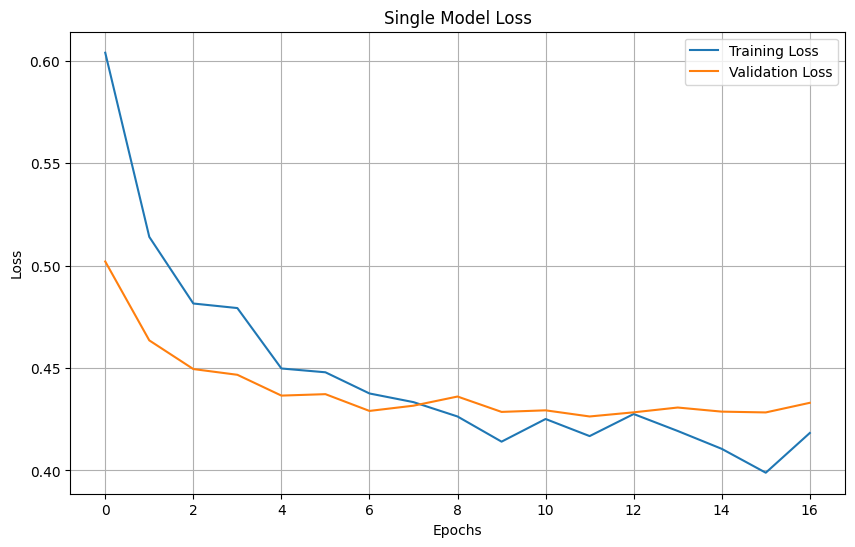

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
# Plot the training and validation
from google.colab import files

# Plot the training and validation loss
plt.figure(figsize=(10, 6))  # Optional: Specify the size of the figure
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Single Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # Optional: Add grid for better readability
plt.savefig("single-model-loss.png")  # Save the figure
plt.show()  # Show the figure

# Download the file
files.download("single-model-loss.png")

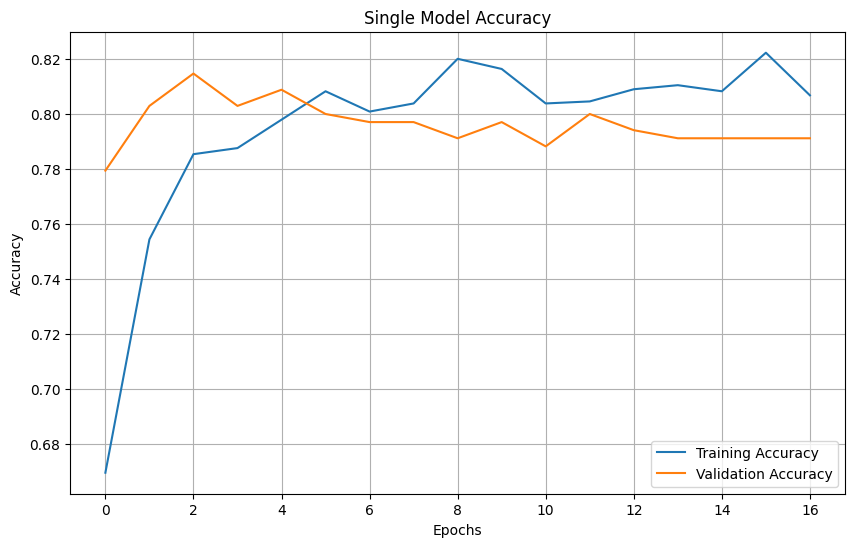

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
# Plot the training and validation accuracy

plt.figure(figsize=(10, 6))  # Optional: Specify the size of the figure
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Single Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)  # Optional: Add grid for better readability
plt.savefig("single-model-accuracy.png")  # Save the figure
plt.show()  # Show the figure

# Download the file
files.download("single-model-accuracy.png")

In [30]:
from sklearn.metrics import accuracy_score, classification_report

# Predict the probabilities on validation set
y_test_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

# Calculate metrics for classification
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy Score: {accuracy:.4f}")

report = classification_report(y_test, y_test_pred)
print("Classification Report:")
print(report)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy Score: 0.8000
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       165
           1       0.81      0.79      0.80       175

    accuracy                           0.80       340
   macro avg       0.80      0.80      0.80       340
weighted avg       0.80      0.80      0.80       340

